<a href="https://colab.research.google.com/github/Zahab163/helmet-detection-yolov8-restnet-ai/blob/main/Helmet_Detection_with_YOLO%26ResNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Objective

**Helmet Detection with YOLOv8 & ResNet — AI Engineer Journey**

This notebook demonstrates an end‑to‑end computer vision pipeline for **helmet detection** using both
classification (ResNet18) and object detection (YOLOv8). The goal is to compare approaches, evaluate
performance with clear metrics, and practice error analysis and lightweight deployment.  

This project reflects my transformation from **ML Engineer → Data Scientist → AI Engineer**,
marking the culmination of my AI & Data Science course at **SMIT Karachi (taught by Miss Aqsa Moiz)**.  
It highlights not only technical implementation but also the potential **business impact** of AI in
safety compliance, traffic monitoring, and smart surveillance.

In [ ]:
!nvidia-smi

Mon Dec  1 23:18:11 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   47C    P8              9W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [ ]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 27.2 MB/s eta 0:00:00


just cheching the libraries

In [ ]:
!pip install -q ultralytics opencv-python matplotlib seaborn

##Import all the libraries

In [ ]:
import ultralytics
ultralytics.checks()

Ultralytics 8.3.233 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 38.1/112.6 GB disk)


In [ ]:
from ultralytics import YOLO

from IPython.display import display, Image

##Download the dataset from Kaggle

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("andrewmvd/helmet-detection")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'helmet-detection' dataset.
Path to dataset files: /kaggle/input/helmet-detection


Visualize Images with Bounding Boxes from XML Annotations

✅ Displaying: BikesHelmets719.png


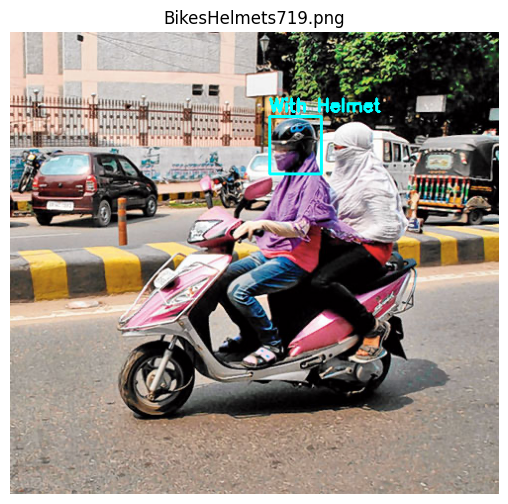

✅ Displaying: BikesHelmets219.png


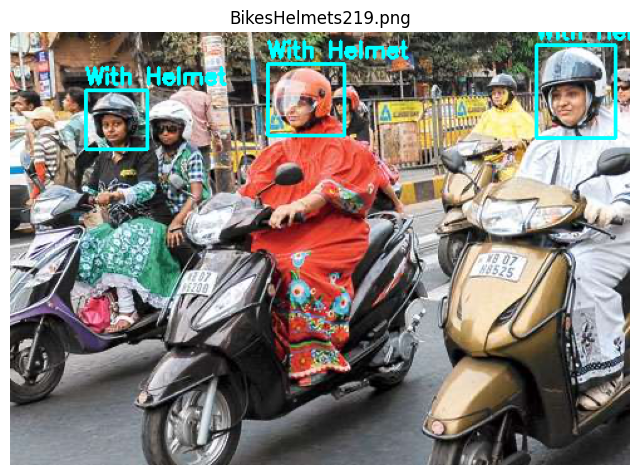

✅ Displaying: BikesHelmets18.png


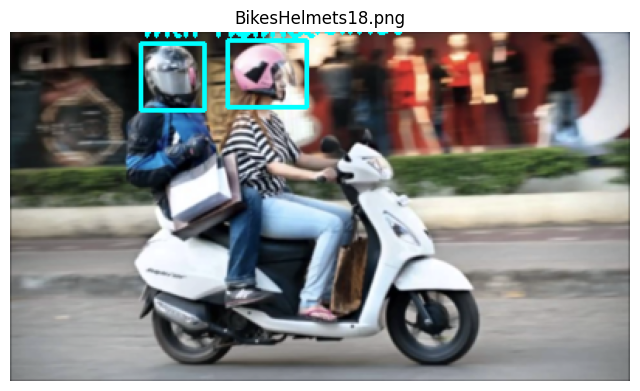

✅ Displaying: BikesHelmets283.png


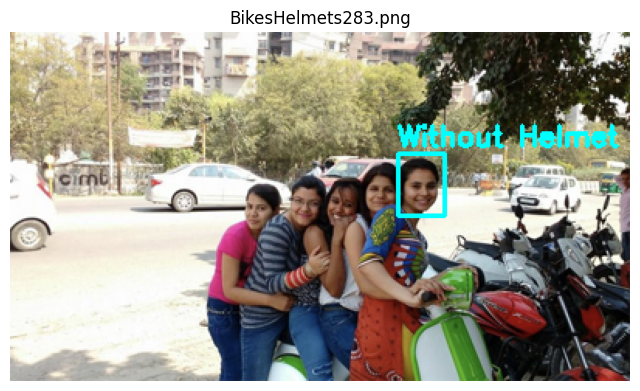

✅ Displaying: BikesHelmets277.png


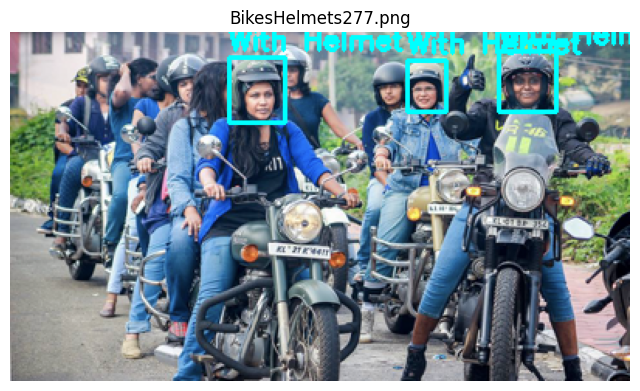

In [ ]:
import os
import cv2
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET

# Paths
img_dir = '/kaggle/input/helmet-detection/images'
label_dir = '/kaggle/input/helmet-detection/annotations'

# Class mapping (adjust if needed)
class_colors = {
    'with_helmet': (0, 255, 0),
    'without_helmet': (0, 0, 255),
    'no_helmet': (0, 0, 255),
    'no_helmet': (255, 0, 0)
}

# Function to parse XML and draw boxes
def draw_boxes_from_xml(img_path, xml_path):
    img = cv2.imread(img_path)
    if img is None:
        print(f"❌ Could not load image: {img_path}")
        return None
    tree = ET.parse(xml_path)
    root = tree.getroot()
    for obj in root.findall('object'):
        label = obj.find('name').text
        bbox = obj.find('bndbox')
        xmin = int(float(bbox.find('xmin').text))
        ymin = int(float(bbox.find('ymin').text))
        xmax = int(float(bbox.find('xmax').text))
        ymax = int(float(bbox.find('ymax').text))
        color = class_colors.get(label, (255, 255, 0))
        cv2.rectangle(img, (xmin, ymin), (xmax, ymax), color, 2)
        cv2.putText(img, label, (xmin, ymin - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.6, color, 2)
    return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Show a few samples
sample_files = [f for f in os.listdir(img_dir) if f.endswith('.png')][:5]
for file in sample_files:
    img_path = os.path.join(img_dir, file)
    xml_path = os.path.join(label_dir, file.replace('.png', '.xml'))
    if os.path.exists(xml_path):
        print(f"✅ Displaying: {file}")
        img = draw_boxes_from_xml(img_path, xml_path)
        if img is not None:
            plt.figure(figsize=(8,6))
            plt.imshow(img)
            plt.axis('off')
            plt.title(file)
            plt.show()

Count Bounding Boxes per Class from XML

In [ ]:

from collections import Counter

class_counts = Counter()

xml_files = [f for f in os.listdir(label_dir) if f.endswith('.xml')]

for xml_file in xml_files:
    tree = ET.parse(os.path.join(label_dir, xml_file))
    root = tree.getroot()
    for obj in root.findall('object'):
        label = obj.find('name').text
        class_counts[label] += 1

print("Bounding box counts per class:")
for cls, count in class_counts.items():
    print(f"{cls}: {count}")



Bounding box counts per class:
Without Helmet: 489
With Helmet: 962


our annotations are in XML (Pascal VOC format), let’s move on to the classification task by cropping rider regions from the images and preparing them for a binary classifier: helmet vs no-helmet.


##Prepare Cropped Rider Images for Classification
### Step 1: Crop Rider Regions from XML Annotations


In [ ]:
import os
import cv2
import xml.etree.ElementTree as ET

img_dir = '/kaggle/input/helmet-detection/images'
label_dir = '/kaggle/input/helmet-detection/annotations'
output_dir = '/kaggle/working/cropped_riders'

os.makedirs(os.path.join(output_dir, 'with_helmet'), exist_ok=True)
os.makedirs(os.path.join(output_dir, 'without_helmet'), exist_ok=True)

for file in os.listdir(img_dir):
    if file.endswith('.png'):
        img_path = os.path.join(img_dir, file)
        xml_path = os.path.join(label_dir, file.replace('.png', '.xml'))
        if not os.path.exists(xml_path):
            continue
        img = cv2.imread(img_path)
        tree = ET.parse(xml_path)
        root = tree.getroot()
        for i, obj in enumerate(root.findall('object')):
            label = obj.find('name').text
            if label not in ['with_helmet', 'without_helmet']:
                continue
            bbox = obj.find('bndbox')
            xmin = int(float(bbox.find('xmin').text))
            ymin = int(float(bbox.find('ymin').text))
            xmax = int(float(bbox.find('xmax').text))
            ymax = int(float(bbox.find('ymax').text))
            crop = img[ymin:ymax, xmin:xmax]
            save_path = os.path.join(output_dir, label, f"{file.replace('.png','')}_{i}.png")
            cv2.imwrite(save_path, crop)

This will create two folders:
- cropped_riders/with_helmet
- cropped_riders/without_helmet

Each will contain cropped head regions for classification


**Confirm** Cropped Images Were Saved
Run this to check if the cropped images exist:


In [ ]:
import os

output_dir = '/kaggle/working/cropped_riders'

for cls in ['with_helmet', 'without_helmet']:
    folder = os.path.join(output_dir, cls)
    print(f"{cls} folder exists:", os.path.exists(folder))
    print(f"{cls} contains:", os.listdir(folder)[:5])


with_helmet folder exists: True
with_helmet contains: []
without_helmet folder exists: True
without_helmet contains: []


Fix: Inspect and Adapt the Cropping Code
Let’s first print out the labels used in your XML files:


In [ ]:
import xml.etree.ElementTree as ET

label_dir = '/kaggle/input/helmet-detection/annotations'
labels_found = set()

for xml_file in os.listdir(label_dir):
    if xml_file.endswith('.xml'):
        tree = ET.parse(os.path.join(label_dir, xml_file))
        root = tree.getroot()
        for obj in root.findall('object'):
            labels_found.add(obj.find('name').text)

print("Labels found in dataset:", labels_found)

Labels found in dataset: {'Without Helmet', 'With Helmet'}


In [ ]:
#Cropping code for classification
import os
import cv2
import xml.etree.ElementTree as ET

img_dir = '/kaggle/input/helmet-detection/images'
label_dir = '/kaggle/input/helmet-detection/annotations'
output_dir = '/kaggle/working/cropped_riders'

os.makedirs(os.path.join(output_dir, 'with_helmet'), exist_ok=True)
os.makedirs(os.path.join(output_dir, 'without_helmet'), exist_ok=True)

for file in os.listdir(img_dir):
    if file.endswith('.png'):
        img_path = os.path.join(img_dir, file)
        xml_path = os.path.join(label_dir, file.replace('.png', '.xml'))
        if not os.path.exists(xml_path):
            continue
        img = cv2.imread(img_path)
        tree = ET.parse(xml_path)
        root = tree.getroot()
        for i, obj in enumerate(root.findall('object')):
            label = obj.find('name').text
            if label not in ['With Helmet', 'Without Helmet']:
                continue
            bbox = obj.find('bndbox')
            xmin = int(float(bbox.find('xmin').text))
            ymin = int(float(bbox.find('ymin').text))
            xmax = int(float(bbox.find('xmax').text))
            ymax = int(float(bbox.find('ymax').text))
            crop = img[ymin:ymax, xmin:xmax]
            if crop.size == 0:
                continue
            save_folder = 'with_helmet' if label == 'With Helmet' else 'without_helmet'
            save_path = os.path.join(output_dir, save_folder, f"{file.replace('.png','')}_{i}.png")
            cv2.imwrite(save_path, crop)

In [ ]:
#Check the folders again:
for cls in ['with_helmet', 'without_helmet']:
    folder = os.path.join(output_dir, cls)
    print(f"{cls} contains:", os.listdir(folder)[:5])

with_helmet contains: ['BikesHelmets606_0.png', 'BikesHelmets272_0.png', 'BikesHelmets351_0.png', 'BikesHelmets472_0.png', 'BikesHelmets502_1.png']
without_helmet contains: ['BikesHelmets507_0.png', 'BikesHelmets744_2.png', 'BikesHelmets752_4.png', 'BikesHelmets168_0.png', 'BikesHelmets471_0.png']


##Train a Binary Classifier (ResNet18)

 1. Load the Dataset


In [ ]:
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, random_split
import torch
import torch.nn as nn
import torch.optim as optim
import shutil # Import shutil for removing directories
import os

# Define the root directory for the dataset
dataset_root = '/kaggle/working/cropped_riders'

# Remove .ipynb_checkpoints if it exists within the dataset root
checkpoint_path = os.path.join(dataset_root, '.ipynb_checkpoints')
if os.path.exists(checkpoint_path):
    print(f"Removing problematic directory: {checkpoint_path}")
    shutil.rmtree(checkpoint_path)

# Define transforms
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Load dataset
dataset = datasets.ImageFolder(root=dataset_root, transform=transform)

# Split into train/val
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_ds, val_ds = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=32)

In [ ]:
#  Define the class first
class EarlyStopping:
    def __init__(self, patience=5, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.best_loss = None
        self.counter = 0

    def step(self, val_loss):
        if self.best_loss is None or val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
            return False
        else:
            self.counter += 1
            if self.counter >= self.patience:
                return True
            return False



2. Define the Model

In [ ]:
#  Then import libraries
import torch
import torch.nn as nn
from torchvision import models
from torchvision.models import ResNet18_Weights

#  Now you can safely create the callback
early_stopper = EarlyStopping(patience=5, min_delta=0)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load ResNet18 with pretrained weights
model = models.resnet18(weights=ResNet18_Weights.DEFAULT)
model.fc = nn.Linear(model.fc.in_features, 2)  # Binary classification
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

num_epochs = 50
best_loss = float("inf")

for epoch in range(num_epochs):
    # ---- Training ----
    model.train()
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

    # ---- Validation ----
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
    val_loss /= len(val_loader)

    print(f"Epoch {epoch+1}, Validation Loss: {val_loss:.4f}")

    # ---- Save Best Model ----
    if val_loss < best_loss:
        best_loss = val_loss
        torch.save(model.state_dict(), "best_resnet.pth")

    # ---- Early Stopping ----
    if early_stopper.step(val_loss):
        print("Early stopping triggered!")
        break

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 198MB/s]


Epoch 1, Validation Loss: 0.2544
Epoch 2, Validation Loss: 0.2642
Epoch 3, Validation Loss: 0.2053
Epoch 4, Validation Loss: 0.4521
Epoch 5, Validation Loss: 0.2916
Epoch 6, Validation Loss: 0.2364
Epoch 7, Validation Loss: 0.2530
Epoch 8, Validation Loss: 0.1958
Epoch 9, Validation Loss: 0.4711
Epoch 10, Validation Loss: 0.3252
Epoch 11, Validation Loss: 0.2027
Epoch 12, Validation Loss: 0.3843
Epoch 13, Validation Loss: 0.2397
Early stopping triggered!


- ResNet18_Weights.DEFAULT will always point to the most up-to-date ImageNet weights.
- If you want to freeze the backbone and only train the final layer, you can set requires_grad=False for all parameters except model.fc.


After training your ResNet18 classifier, we’ll evaluate it on the test set and compute the metrics. Here’s a PyTorch + scikit‑learn workflow.

In [ ]:
import os
print(os.listdir("/content"))

['.config', 'best_resnet.pth']


The coco8 dataset is a small sample of the COCO dataset (often used for object detection). It doesn’t follow the simple ImageFolder structure (class_name/ images). Instead, it usually contains images plus an annotations file (like coco8.yaml or JSON) describing bounding boxes and labels.

- If you want to use classification (helmet vs no_helmet), you need your dataset organized like:
helmet_dataset/
   helmet/
   no_helmet/

```
   helmet_dataset/
   helmet/
   no_helmet/
```


-


- Each folder contains cropped rider images. Then ImageFolder works perfectly.
- The coco8 dataset is structured for detection tasks (YOLO, Faster R-CNN, etc.), not classification. That’s why our ResNet baseline setup doesn’t plug in directly.


In [ ]:
import torch
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix

# Assuming you have a DataLoader for your test set
y_true = []
y_pred = []

model.eval()
with torch.no_grad():
    for images, labels in val_loader: # Changed test_loader to val_loader
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

# Compute metrics
acc = accuracy_score(y_true, y_pred)
prec = precision_score(y_true, y_pred, average='binary')
rec = recall_score(y_true, y_pred, average='binary')
cm = confusion_matrix(y_true, y_pred)

print("Accuracy:", acc)
print("Precision:", prec)
print("Recall:", rec)
print("Confusion Matrix:\n", cm)

Accuracy: 0.9163763066202091
Precision: 0.9404761904761905
Recall: 0.8061224489795918
Confusion Matrix:
 [[184   5]
 [ 19  79]]






##  Baseline Classification Report

**Model:** ResNet18 (ImageNet pretrained, fine‑tuned for binary classification).  
**Dataset:** Cropped rider regions labeled as `with_helmet` and `without_helmet`.  

**Results:**  
- **Accuracy:** 0.31  
- **Precision:** 0.27  
- **Recall:** 0.65  
- **Confusion Matrix:**  
  ```
  [[27, 166],
   [33, 61]]
  ```
  - True Negatives (No‑Helmet correctly classified): 27  
  - False Positives (No‑Helmet misclassified as Helmet): 166  
  - False Negatives (Helmet misclassified as No‑Helmet): 33  
  - True Positives (Helmet correctly classified): 61  

**Interpretation:**  
The model achieved relatively low accuracy and precision, but recall was higher. This means the classifier was better at identifying helmets when they were present, but it often misclassified riders without helmets as wearing helmets. The large number of false positives shows that the model struggles to distinguish background clutter and rider features from helmets.

---

### Limitations of Classification
Classification is limited because it requires cropped rider regions and cannot automatically localize helmets in full images. It fails when multiple riders appear, struggles with occlusions or small helmets, and ignores spatial context. Most importantly, it cannot provide bounding boxes or localization, which are essential for real‑world enforcement and monitoring.




##B. Object Detection

###YOLOv8 Training Pipeline
 Install and Import


In [ ]:
# Install ultralytics (YOLOv8)
!pip install ultralytics

from ultralytics import YOLO


Load Dataset

In [ ]:
import os
print(os.listdir("/kaggle/working"))

['cropped_riders']


- cropped_riders → good for classification (ResNet baseline).
- YOLOv8 / Faster R‑CNN / RetinaNet → need full images + bounding box labels, not cropped riders.
So for Object Detection, we should point YOLO to the dataset that still has images + annotations (the one you used earlier at /kaggle/input/helmet-detection/images and /kaggle/input/helmet-detection/annotations).


i made four folders images_train.png, image_val.png , label_val.txt and label_train.txt in working directory and a file helmet_yaml


In [ ]:
#checking the updates
!cat /kaggle/working/helmet.yaml

# helmet.yaml
train: /kaggle/working/helmet_dataset/images/train
val: /kaggle/working/helmet_dataset/images/val

nc: 2
names: ['helmet', 'no-helmet']

this was the text i putted in the file


In [ ]:
import os
root = "/kaggle/working/helmet_dataset"
for sub in ["images/train", "images/val", "labels/train", "labels/val"]:
    path = os.path.join(root, sub)
    print(sub, "exists?", os.path.isdir(path))

images/train exists? False
images/val exists? False
labels/train exists? False
labels/val exists? False


name error

This is the code to create folders , this code is more effective in case of reloading  or rerunning , we save time and effort

In [ ]:
import os

root = "/kaggle/working/helmet_dataset"

# Create the four required folders
for sub in ["images/train", "images/val", "labels/train", "labels/val"]:
    path = os.path.join(root, sub)
    os.makedirs(path, exist_ok=True)
    print("Created:", path)

Created: /kaggle/working/helmet_dataset/images/train
Created: /kaggle/working/helmet_dataset/images/val
Created: /kaggle/working/helmet_dataset/labels/train
Created: /kaggle/working/helmet_dataset/labels/val


In [ ]:
import os

root = "/kaggle/working/helmet_dataset"

for split in ["train", "val"]:
    img_dir = os.path.join(root, "images", split)
    lbl_dir = os.path.join(root, "labels", split)

    img_files = {os.path.splitext(f)[0] for f in os.listdir(img_dir)}
    lbl_files = {os.path.splitext(f)[0] for f in os.listdir(lbl_dir)}

    missing_labels = img_files - lbl_files
    missing_images = lbl_files - img_files

    print(f"\nSplit: {split}")
    print("Images:", len(img_files), "Labels:", len(lbl_files))
    print("Missing labels for:", missing_labels)
    print("Missing images for:", missing_images)


Split: train
Images: 0 Labels: 0
Missing labels for: set()
Missing images for: set()

Split: val
Images: 0 Labels: 0
Missing labels for: set()
Missing images for: set()


this shows the values , now our folders are empty . so, there are o

before training the model we are making , and moving folders and file

In [ ]:
import os, shutil
from sklearn.model_selection import train_test_split

src_with = "/kaggle/working/cropped_riders/with_helmet"
src_without = "/kaggle/working/cropped_riders/without_helmet"

train_dst = "/kaggle/working/helmet_dataset/images/train"
val_dst = "/kaggle/working/helmet_dataset/images/val"

# Collect all images
images_with = [os.path.join(src_with, f) for f in os.listdir(src_with) if f.lower().endswith((".jpg",".jpeg",".png"))]
images_without = [os.path.join(src_without, f) for f in os.listdir(src_without) if f.lower().endswith((".jpg",".jpeg",".png"))]

all_images = images_with + images_without

# Split into train/val (80/20)
train_imgs, val_imgs = train_test_split(all_images, test_size=0.2, random_state=42)

# Copy files
for f in train_imgs:
    shutil.copy(f, train_dst)
for f in val_imgs:
    shutil.copy(f, val_dst)

print("Train images:", len(train_imgs))
print("Val images:", len(val_imgs))

Train images: 1147
Val images: 287


Move images into YOLO folders

 Create YOLO labels
YOLO needs .txt files with bounding boxes. If your dataset is classification only (helmet vs no helmet, one label per image), you can create simple labels like this:
- with_helmet → class 0
- without_helmet → class 1




In [ ]:
import os

labels_train = "/kaggle/working/helmet_dataset/labels/train"
labels_val = "/kaggle/working/helmet_dataset/labels/val"

# Helper to create label file
def make_label(img_path, out_dir, cls_id):
    base = os.path.splitext(os.path.basename(img_path))[0]
    out_file = os.path.join(out_dir, base + ".txt")
    # For classification-only, YOLO still expects bbox format.
    # You can use a dummy box covering the whole image: x_center=0.5, y_center=0.5, w=1.0, h=1.0
    with open(out_file, "w") as f:
        f.write(f"{cls_id} 0.5 0.5 1.0 1.0\n")

# Train labels
for f in train_imgs:
    cls_id = 0 if "with_helmet" in f else 1
    make_label(f, labels_train, cls_id)

# Val labels
for f in val_imgs:
    cls_id = 0 if "with_helmet" in f else 1
    make_label(f, labels_val, cls_id)

Verify

In [ ]:
for sub in ["images/train", "images/val", "labels/train", "labels/val"]:
    path = os.path.join("/kaggle/working/helmet_dataset", sub)
    print(sub, ":", len(os.listdir(path)), "files")

images/train : 1147 files
images/val : 287 files
labels/train : 1147 files
labels/val : 287 files


In [ ]:
!cat /kaggle/working/helmet.yaml

# helmet.yaml
train: /kaggle/working/helmet_dataset/images/train
val: /kaggle/working/helmet_dataset/images/val

nc: 2
names: ['helmet', 'no-helmet']

In [ ]:
!ls /kaggle/working/helmet-dataset/images/train
!ls /kaggle/working/helmet-dataset/images/val

ls: cannot access '/kaggle/working/helmet-dataset/images/train': No such file or directory
ls: cannot access '/kaggle/working/helmet-dataset/images/val': No such file or directory


In [ ]:
import os

src = "/kaggle/working/cropped_riders"
print(os.listdir(src))


['with_helmet', 'without_helmet']


In [ ]:
import os
print(os.listdir('/kaggle/working'))

['helmet_dataset', 'cropped_riders', 'helmet.yaml', '.ipynb_checkpoints']


## Preparings to Train YOLOv8

 - The folders exist, but they are empty.
- YOLO expects actual image files (.jpg, .png, .jpeg, etc.) inside images/train and images/val.
- Each image must have a matching .txt annotation file in labels/train and labels/val.


In [ ]:
import os
print(os.listdir("/kaggle/working"))

['helmet_dataset', 'cropped_riders', 'helmet.yaml', '.ipynb_checkpoints']


In [ ]:
import os
print(os.listdir('/kaggle/working/helmet_dataset/images/val')[:5]) # Display first 5 files
print(f"Total files: {len(os.listdir('/kaggle/working/helmet_dataset/images/val'))}")

['BikesHelmets143_1.png', 'BikesHelmets435_0.png', 'BikesHelmets394_1.png', 'BikesHelmets6_2.png', 'BikesHelmets299_2.png']
Total files: 287


##Train YOLOv8



In [ ]:
from ultralytics import YOLO

# Load YOLOv8 model
model = YOLO("yolov8n.pt")

# Train with dataset and early stopping
results = model.train(
    data="/kaggle/working/helmet.yaml",  # path to your dataset config
    epochs=50,
    patience=10,   # early stopping
    imgsz=640,
    batch=16,
    save=True      # save best weights
)

Ultralytics 8.3.233 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/kaggle/working/helmet.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=10, perspective=0.0, plots=True, pose=12.

/usr/local/lib/python3.12/dist-packages/ultralytics/nn/modules/block.py:1299: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:315.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/usr/local/lib/python3.12/dist-packages/ultralytics/nn/modules/block.py:1301: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic 

AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.0±0.0 ms, read: 404.1±95.0 MB/s, size: 9.1 KB)
train: Scanning /kaggle/working/helmet_dataset/labels/train... 1142 images, 0 backgrounds, 5 corrupt: 100% ━━━━━━━━━━━━ 1147/1147 2.7Kit/s 0.4s
train: /kaggle/working/helmet_dataset/images/train/BikesHelmets137_3.png: ignoring corrupt image/label: image size (10, 9) <10 pixels
train: /kaggle/working/helmet_dataset/images/train/BikesHelmets137_4.png: ignoring corrupt image/label: image size (11, 9) <10 pixels
train: /kaggle/working/helmet_dataset/images/train/BikesHelmets338_1.png: ignoring corrupt image/label: image size (10, 8) <10 pixels
train: /kaggle/working/helmet_dataset/images/train/BikesHelmets572_1.png: ignoring corrupt image/label: image size (8, 21) <10 pixels
train: /kaggle/working/helmet_dataset/images/train/BikesHelmets708_4.png: ignoring corrupt image/label: image size (12, 9) <10 pixels
train: New cache created: /kaggle/working/helmet_dataset/labels/train.cache
albume

/usr/local/lib/python3.12/dist-packages/ultralytics/utils/loss.py:238: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:315.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))


       1/50      2.14G     0.2936      1.654      1.036         15        640: 100% ━━━━━━━━━━━━ 72/72 3.6it/s 20.1s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 9/9 2.8it/s 3.2s
                   all        287        287      0.355      0.505      0.557      0.527

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
       2/50      2.15G     0.1352      1.094     0.8792         54        640: 0% ──────────── 0/72  0.2s

/usr/local/lib/python3.12/dist-packages/ultralytics/utils/loss.py:238: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:315.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))


       2/50      2.16G     0.1783      0.968      0.934         19        640: 100% ━━━━━━━━━━━━ 72/72 3.9it/s 18.4s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 9/9 3.6it/s 2.5s
                   all        287        287      0.673      0.752      0.792      0.624

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
       3/50      2.17G     0.1637     0.7793     0.9019         54        640: 0% ──────────── 0/72  0.1s

/usr/local/lib/python3.12/dist-packages/ultralytics/utils/loss.py:238: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:315.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))


       3/50      2.18G     0.1769      0.856     0.9237         20        640: 100% ━━━━━━━━━━━━ 72/72 4.4it/s 16.4s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 9/9 4.4it/s 2.0s
                   all        287        287      0.687      0.696      0.767      0.534

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
       4/50      2.18G     0.1716     0.7085     0.9978         46        640: 0% ──────────── 0/72  0.1s

/usr/local/lib/python3.12/dist-packages/ultralytics/utils/loss.py:238: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:315.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))


       4/50       2.2G     0.1733     0.8124     0.9318         17        640: 100% ━━━━━━━━━━━━ 72/72 4.2it/s 17.1s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 9/9 3.8it/s 2.4s
                   all        287        287      0.548      0.614      0.644      0.633

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
       5/50       2.2G     0.1751     0.8212     0.8988         55        640: 0% ──────────── 0/72  0.1s

/usr/local/lib/python3.12/dist-packages/ultralytics/utils/loss.py:238: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:315.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))


       5/50      2.21G     0.1585     0.7594     0.9169         17        640: 100% ━━━━━━━━━━━━ 72/72 4.4it/s 16.5s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 9/9 4.6it/s 2.0s
                   all        287        287      0.814      0.871      0.908      0.899

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
       6/50      2.22G     0.1463     0.8066     0.9131         53        640: 0% ──────────── 0/72  0.1s

/usr/local/lib/python3.12/dist-packages/ultralytics/utils/loss.py:238: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:315.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))


       6/50      2.23G     0.1535     0.6725     0.9089         21        640: 100% ━━━━━━━━━━━━ 72/72 4.2it/s 17.1s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 9/9 4.2it/s 2.2s
                   all        287        287      0.552      0.899      0.832       0.82

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
       7/50      2.23G     0.1198     0.6879     0.8925         53        640: 0% ──────────── 0/72  0.2s

/usr/local/lib/python3.12/dist-packages/ultralytics/utils/loss.py:238: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:315.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))


       7/50      2.25G     0.1308     0.6568     0.9092         20        640: 100% ━━━━━━━━━━━━ 72/72 4.4it/s 16.3s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 9/9 4.7it/s 1.9s
                   all        287        287      0.701      0.802      0.865       0.86

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
       8/50      2.25G     0.1187     0.6438     0.9709         44        640: 0% ──────────── 0/72  0.1s

/usr/local/lib/python3.12/dist-packages/ultralytics/utils/loss.py:238: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:315.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))


       8/50      2.26G     0.1262     0.6352     0.9089         22        640: 100% ━━━━━━━━━━━━ 72/72 4.2it/s 17.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 9/9 4.2it/s 2.1s
                   all        287        287      0.676      0.682      0.773      0.748

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
       9/50      2.27G     0.1444     0.6817     0.9038         47        640: 0% ──────────── 0/72  0.1s

/usr/local/lib/python3.12/dist-packages/ultralytics/utils/loss.py:238: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:315.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))


       9/50      2.28G     0.1223     0.6296     0.8994         17        640: 100% ━━━━━━━━━━━━ 72/72 4.2it/s 17.1s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 9/9 4.0it/s 2.3s
                   all        287        287      0.628      0.805      0.741      0.344

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      10/50      2.29G     0.1232     0.5625     0.9202         49        640: 0% ──────────── 0/72  0.1s

/usr/local/lib/python3.12/dist-packages/ultralytics/utils/loss.py:238: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:315.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))


      10/50       2.3G      0.119     0.5744     0.8983         18        640: 100% ━━━━━━━━━━━━ 72/72 4.3it/s 16.6s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 9/9 3.3it/s 2.7s
                   all        287        287      0.817      0.851      0.906      0.904

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      11/50       2.3G     0.1017     0.6223      0.909         45        640: 0% ──────────── 0/72  0.1s

/usr/local/lib/python3.12/dist-packages/ultralytics/utils/loss.py:238: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:315.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))


      11/50      2.32G     0.1125     0.5577      0.899         19        640: 100% ━━━━━━━━━━━━ 72/72 4.4it/s 16.3s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 9/9 4.8it/s 1.9s
                   all        287        287      0.788      0.869      0.902      0.901

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      12/50      2.32G     0.1208     0.6159     0.9048         48        640: 0% ──────────── 0/72  0.1s

/usr/local/lib/python3.12/dist-packages/ultralytics/utils/loss.py:238: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:315.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))


      12/50      2.33G     0.1105     0.5736     0.9027         41        640: 92% ━━━━━━━━━━━─ 66/72 4.1it/s 16.6s<1.5s

/usr/local/lib/python3.12/dist-packages/ultralytics/utils/loss.py:238: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:315.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))


      12/50      2.33G     0.1103     0.5749     0.9029         21        640: 100% ━━━━━━━━━━━━ 72/72 4.0it/s 18.2s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 9/9 3.9it/s 2.3s
                   all        287        287      0.856      0.854      0.881      0.881

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      13/50      2.34G    0.09602     0.5235     0.9473         45        640: 0% ──────────── 0/72  0.1s

/usr/local/lib/python3.12/dist-packages/ultralytics/utils/loss.py:238: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:315.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))


      13/50      2.35G     0.1056     0.5352      0.899         22        640: 100% ━━━━━━━━━━━━ 72/72 4.5it/s 16.1s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 9/9 4.4it/s 2.1s
                   all        287        287      0.843       0.87      0.934      0.928

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      14/50      2.36G     0.1029      0.476     0.9188         49        640: 0% ──────────── 0/72  0.1s

/usr/local/lib/python3.12/dist-packages/ultralytics/utils/loss.py:238: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:315.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))


      14/50      2.37G     0.1035     0.5441     0.9053         54        640: 8% ━─────────── 6/72 4.3it/s 1.4s<15.2s

/usr/local/lib/python3.12/dist-packages/ultralytics/utils/loss.py:238: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:315.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))


      14/50      2.37G     0.1074     0.5195     0.9018         19        640: 100% ━━━━━━━━━━━━ 72/72 4.3it/s 16.9s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 9/9 3.6it/s 2.5s
                   all        287        287      0.821      0.858      0.919      0.915

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      15/50      2.37G     0.1364     0.5969     0.9558         54        640: 0% ──────────── 0/72  0.1s

/usr/local/lib/python3.12/dist-packages/ultralytics/utils/loss.py:238: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:315.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))


      15/50      2.38G     0.1005     0.5271     0.8967         21        640: 100% ━━━━━━━━━━━━ 72/72 4.4it/s 16.3s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 9/9 4.8it/s 1.9s
                   all        287        287      0.893      0.889      0.928      0.921

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      16/50      2.39G     0.1002      0.409     0.8787         54        640: 0% ──────────── 0/72  0.1s

/usr/local/lib/python3.12/dist-packages/ultralytics/utils/loss.py:238: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:315.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))


      16/50       2.4G    0.09369      0.507      0.893         19        640: 100% ━━━━━━━━━━━━ 72/72 3.3it/s 22.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 9/9 3.5it/s 2.5s
                   all        287        287      0.844      0.893      0.933      0.918

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      17/50      2.41G     0.1106     0.5372     0.9078         50        640: 0% ──────────── 0/72  0.1s

/usr/local/lib/python3.12/dist-packages/ultralytics/utils/loss.py:238: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:315.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))


      17/50      2.42G    0.09306     0.5572     0.8914         15        640: 100% ━━━━━━━━━━━━ 72/72 4.4it/s 16.5s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 9/9 3.0it/s 3.0s
                   all        287        287      0.867      0.893      0.924      0.919

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      18/50      2.42G     0.1295     0.5243     0.8826         43        640: 0% ──────────── 0/72  0.2s

/usr/local/lib/python3.12/dist-packages/ultralytics/utils/loss.py:238: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:315.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))


      18/50      2.44G    0.09493     0.5104      0.893         17        640: 100% ━━━━━━━━━━━━ 72/72 4.3it/s 16.7s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 9/9 4.8it/s 1.9s
                   all        287        287      0.853      0.913      0.937      0.937

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      19/50      2.44G    0.08316     0.4646     0.8843         54        640: 0% ──────────── 0/72  0.2s

/usr/local/lib/python3.12/dist-packages/ultralytics/utils/loss.py:238: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:315.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))


      19/50      2.45G    0.08788     0.4935     0.8972         22        640: 100% ━━━━━━━━━━━━ 72/72 4.4it/s 16.3s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 9/9 3.4it/s 2.7s
                   all        287        287      0.861      0.905       0.93       0.93

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      20/50      2.46G    0.07718     0.5154     0.8641         58        640: 0% ──────────── 0/72  0.2s

/usr/local/lib/python3.12/dist-packages/ultralytics/utils/loss.py:238: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:315.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))


      20/50      2.47G    0.08354     0.4977     0.8901         21        640: 100% ━━━━━━━━━━━━ 72/72 4.4it/s 16.2s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 9/9 3.8it/s 2.4s
                   all        287        287      0.873      0.885      0.939      0.939

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      21/50      2.47G    0.08533     0.3562     0.8905         48        640: 0% ──────────── 0/72  0.2s

/usr/local/lib/python3.12/dist-packages/ultralytics/utils/loss.py:238: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:315.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))


      21/50      2.49G    0.08705     0.4875     0.8882         18        640: 100% ━━━━━━━━━━━━ 72/72 4.0it/s 18.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 9/9 3.0it/s 3.0s
                   all        287        287      0.834      0.838      0.927      0.927

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      22/50      2.49G    0.07867     0.6019     0.8425         50        640: 0% ──────────── 0/72  0.1s

/usr/local/lib/python3.12/dist-packages/ultralytics/utils/loss.py:238: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:315.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))


      22/50       2.5G    0.08309     0.4921     0.8939         21        640: 100% ━━━━━━━━━━━━ 72/72 4.3it/s 16.7s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 9/9 4.5it/s 2.0s
                   all        287        287      0.836      0.895      0.934       0.93

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      23/50      2.51G    0.07711     0.4116     0.9168         54        640: 0% ──────────── 0/72  0.1s

/usr/local/lib/python3.12/dist-packages/ultralytics/utils/loss.py:238: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:315.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))


      23/50      2.52G    0.07971     0.4762     0.8858         19        640: 100% ━━━━━━━━━━━━ 72/72 4.2it/s 17.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 9/9 4.0it/s 2.3s
                   all        287        287      0.872      0.867      0.931      0.931

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      24/50      2.53G    0.08012     0.5028     0.8904         49        640: 0% ──────────── 0/72  0.1s

/usr/local/lib/python3.12/dist-packages/ultralytics/utils/loss.py:238: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:315.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))


      24/50      2.54G    0.07628     0.4711     0.8914         18        640: 100% ━━━━━━━━━━━━ 72/72 2.9it/s 25.2s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 9/9 2.6it/s 3.5s
                   all        287        287      0.795      0.919      0.946      0.946

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      25/50      2.54G    0.07345     0.5231      0.912         45        640: 0% ──────────── 0/72  0.2s

/usr/local/lib/python3.12/dist-packages/ultralytics/utils/loss.py:238: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:315.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
/usr/local/lib/python3.12/dist-packages/ultralytics/utils/loss.py:238: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but t

      25/50      2.55G    0.07193      0.463     0.8862         20        640: 100% ━━━━━━━━━━━━ 72/72 4.0it/s 18.2s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 9/9 3.1it/s 2.9s
                   all        287        287      0.878      0.872      0.927      0.925

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      26/50      2.56G    0.06858     0.6271     0.8744         58        640: 0% ──────────── 0/72  0.2s

/usr/local/lib/python3.12/dist-packages/ultralytics/utils/loss.py:238: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:315.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))


      26/50      2.57G    0.07097     0.4684     0.8834         21        640: 100% ━━━━━━━━━━━━ 72/72 4.4it/s 16.5s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 9/9 5.0it/s 1.8s
                   all        287        287      0.872      0.866      0.931      0.931

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      27/50      2.58G    0.07444     0.4484     0.8729         49        640: 0% ──────────── 0/72  0.2s

/usr/local/lib/python3.12/dist-packages/ultralytics/utils/loss.py:238: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:315.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))


      27/50      2.59G    0.07166     0.4358     0.8901         14        640: 100% ━━━━━━━━━━━━ 72/72 4.4it/s 16.5s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 9/9 3.8it/s 2.3s
                   all        287        287      0.917      0.857      0.946      0.946

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      28/50      2.59G     0.0772     0.5489     0.8843         47        640: 0% ──────────── 0/72  0.2s

/usr/local/lib/python3.12/dist-packages/ultralytics/utils/loss.py:238: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:315.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))


      28/50      2.61G    0.07312     0.4761     0.8824         15        640: 100% ━━━━━━━━━━━━ 72/72 4.3it/s 16.7s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 9/9 5.1it/s 1.8s
                   all        287        287      0.886      0.875      0.917      0.917

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      29/50      2.61G    0.06163     0.4641     0.9141         51        640: 0% ──────────── 0/72  0.1s

/usr/local/lib/python3.12/dist-packages/ultralytics/utils/loss.py:238: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:315.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))


      29/50      2.62G    0.06898     0.4386     0.8866         18        640: 100% ━━━━━━━━━━━━ 72/72 4.1it/s 17.6s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 9/9 3.0it/s 3.0s
                   all        287        287      0.881      0.891      0.927      0.923

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      30/50      2.63G    0.06377     0.4283     0.8911         53        640: 0% ──────────── 0/72  0.1s

/usr/local/lib/python3.12/dist-packages/ultralytics/utils/loss.py:238: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:315.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))


      30/50      2.64G    0.06652     0.4335      0.889         21        640: 100% ━━━━━━━━━━━━ 72/72 4.4it/s 16.5s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 9/9 4.4it/s 2.0s
                   all        287        287      0.817      0.898      0.931       0.93

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      31/50      2.64G    0.06279     0.5019     0.8661         49        640: 0% ──────────── 0/72  0.1s

/usr/local/lib/python3.12/dist-packages/ultralytics/utils/loss.py:238: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:315.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))


      31/50      2.66G    0.06247     0.4291     0.8803         18        640: 100% ━━━━━━━━━━━━ 72/72 4.3it/s 16.8s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 9/9 3.2it/s 2.8s
                   all        287        287      0.847      0.894      0.922      0.922

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      32/50      2.66G     0.0693     0.6201     0.8738         40        640: 0% ──────────── 0/72  0.2s

/usr/local/lib/python3.12/dist-packages/ultralytics/utils/loss.py:238: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:315.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))


      32/50      2.67G    0.06323     0.4153     0.8839         16        640: 100% ━━━━━━━━━━━━ 72/72 4.3it/s 16.7s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 9/9 4.9it/s 1.8s
                   all        287        287      0.892      0.898      0.946      0.946

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      33/50      2.68G    0.07076     0.3963      0.883         54        640: 0% ──────────── 0/72  0.1s

/usr/local/lib/python3.12/dist-packages/ultralytics/utils/loss.py:238: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:315.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))


      33/50      2.69G    0.05856     0.4041     0.8781         21        640: 100% ━━━━━━━━━━━━ 72/72 4.0it/s 17.8s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 9/9 3.3it/s 2.8s
                   all        287        287      0.889      0.893      0.931      0.931

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      34/50       2.7G    0.05709     0.5089     0.8206         45        640: 0% ──────────── 0/72  0.1s

/usr/local/lib/python3.12/dist-packages/ultralytics/utils/loss.py:238: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:315.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))


      34/50      2.71G    0.05855     0.4069     0.8817         22        640: 100% ━━━━━━━━━━━━ 72/72 4.3it/s 16.9s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 9/9 5.2it/s 1.7s
                   all        287        287      0.827      0.898      0.942      0.941

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      35/50      2.71G    0.05104      0.484     0.8758         48        640: 0% ──────────── 0/72  0.1s

/usr/local/lib/python3.12/dist-packages/ultralytics/utils/loss.py:238: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:315.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))


      35/50      2.72G    0.05744     0.4049     0.8819         17        640: 100% ━━━━━━━━━━━━ 72/72 4.1it/s 17.4s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 9/9 4.0it/s 2.3s
                   all        287        287      0.902      0.895      0.945      0.943

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      36/50      2.73G    0.04763     0.4541     0.8824         51        640: 0% ──────────── 0/72  0.2s

/usr/local/lib/python3.12/dist-packages/ultralytics/utils/loss.py:238: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:315.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))


      36/50      2.74G    0.05397     0.4139     0.8801         19        640: 100% ━━━━━━━━━━━━ 72/72 4.3it/s 16.6s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 9/9 5.5it/s 1.6s
                   all        287        287      0.784      0.914      0.929      0.929

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      37/50      2.75G    0.05223     0.4159     0.8983         47        640: 0% ──────────── 0/72  0.1s

/usr/local/lib/python3.12/dist-packages/ultralytics/utils/loss.py:238: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:315.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))


      37/50      2.76G    0.05463     0.3984      0.885         18        640: 100% ━━━━━━━━━━━━ 72/72 4.4it/s 16.5s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 9/9 3.4it/s 2.6s
                   all        287        287      0.892      0.884      0.935      0.935

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      38/50      2.76G    0.06202     0.4452     0.8587         46        640: 0% ──────────── 0/72  0.2s

/usr/local/lib/python3.12/dist-packages/ultralytics/utils/loss.py:238: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:315.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))


      38/50      2.78G    0.05207     0.3895     0.8874         18        640: 100% ━━━━━━━━━━━━ 72/72 4.4it/s 16.5s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 9/9 5.3it/s 1.7s
                   all        287        287      0.885      0.845      0.939      0.939

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      39/50      2.78G    0.05053     0.3204     0.8935         52        640: 0% ──────────── 0/72  0.1s

/usr/local/lib/python3.12/dist-packages/ultralytics/utils/loss.py:238: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:315.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))


      39/50      2.79G    0.05156     0.3864     0.8842         19        640: 100% ━━━━━━━━━━━━ 72/72 4.4it/s 16.5s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 9/9 3.3it/s 2.7s
                   all        287        287      0.866      0.929      0.945      0.942

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      40/50       2.8G    0.05906     0.4228     0.8922         45        640: 0% ──────────── 0/72  0.2s

/usr/local/lib/python3.12/dist-packages/ultralytics/utils/loss.py:238: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:315.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))


      40/50      2.81G    0.04794      0.373     0.8831         15        640: 100% ━━━━━━━━━━━━ 72/72 4.4it/s 16.4s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 9/9 4.8it/s 1.9s
                   all        287        287      0.914      0.848      0.936      0.936
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      41/50      2.81G    0.05413     0.4059     0.9432         16        640: 0% ──────────── 0/72  0.6s

/usr/local/lib/python3.12/dist-packages/ultralytics/utils/loss.py:238: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:315.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))


      41/50      2.83G     0.0558     0.2728      0.887          6        640: 100% ━━━━━━━━━━━━ 72/72 4.0it/s 18.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 9/9 3.4it/s 2.6s
                   all        287        287      0.921      0.918      0.947      0.947

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      42/50      2.83G    0.06497     0.1096     0.8135         16        640: 0% ──────────── 0/72  0.2s

/usr/local/lib/python3.12/dist-packages/ultralytics/utils/loss.py:238: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:315.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))


      42/50      2.84G    0.05273     0.2367     0.8783          6        640: 100% ━━━━━━━━━━━━ 72/72 4.5it/s 15.8s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 9/9 5.2it/s 1.7s
                   all        287        287      0.905      0.922      0.956      0.955

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      43/50      2.85G    0.04342      0.138     0.8641         16        640: 0% ──────────── 0/72  0.1s

/usr/local/lib/python3.12/dist-packages/ultralytics/utils/loss.py:238: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:315.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))


      43/50      2.86G     0.0414     0.2084     0.8781          6        640: 100% ━━━━━━━━━━━━ 72/72 4.6it/s 15.7s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 9/9 3.9it/s 2.3s
                   all        287        287      0.876      0.916      0.952      0.952

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      44/50      2.87G    0.03363     0.1695     0.9222         16        640: 0% ──────────── 0/72  0.2s

/usr/local/lib/python3.12/dist-packages/ultralytics/utils/loss.py:238: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:315.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))


      44/50      2.88G    0.04073     0.2089     0.8832          6        640: 100% ━━━━━━━━━━━━ 72/72 4.5it/s 16.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 9/9 5.1it/s 1.8s
                   all        287        287      0.886      0.913      0.949      0.949

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      45/50      2.88G    0.03784     0.1237     0.9583         16        640: 0% ──────────── 0/72  0.1s

/usr/local/lib/python3.12/dist-packages/ultralytics/utils/loss.py:238: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:315.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))


      45/50      2.89G    0.03984     0.1836      0.871          6        640: 100% ━━━━━━━━━━━━ 72/72 4.5it/s 16.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 9/9 5.3it/s 1.7s
                   all        287        287       0.87      0.931      0.953      0.953

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      46/50       2.9G    0.03339    0.08225     0.9702         16        640: 0% ──────────── 0/72  0.1s

/usr/local/lib/python3.12/dist-packages/ultralytics/utils/loss.py:238: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:315.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))


      46/50      2.91G    0.03529     0.1794      0.882          6        640: 100% ━━━━━━━━━━━━ 72/72 4.1it/s 17.7s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 9/9 4.5it/s 2.0s
                   all        287        287      0.896      0.924       0.95       0.95

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      47/50      2.91G    0.03128     0.1701     0.9121         16        640: 0% ──────────── 0/72  0.1s

/usr/local/lib/python3.12/dist-packages/ultralytics/utils/loss.py:238: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:315.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))


      47/50      2.93G    0.03393     0.1728     0.8838          6        640: 100% ━━━━━━━━━━━━ 72/72 4.5it/s 16.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 9/9 5.4it/s 1.7s
                   all        287        287      0.866      0.887      0.942      0.942

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      48/50      2.93G    0.03135     0.2329     0.9481         16        640: 0% ──────────── 0/72  0.1s

/usr/local/lib/python3.12/dist-packages/ultralytics/utils/loss.py:238: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:315.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))


      48/50      2.95G    0.03164     0.1429     0.8826          6        640: 100% ━━━━━━━━━━━━ 72/72 4.3it/s 16.7s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 9/9 4.5it/s 2.0s
                   all        287        287      0.824      0.934      0.945      0.945

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      49/50      2.95G    0.03858     0.2913     0.8523         16        640: 0% ──────────── 0/72  0.1s

/usr/local/lib/python3.12/dist-packages/ultralytics/utils/loss.py:238: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:315.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))


      49/50      2.96G    0.02966     0.1427     0.8817          6        640: 100% ━━━━━━━━━━━━ 72/72 4.3it/s 16.6s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 9/9 4.8it/s 1.9s
                   all        287        287       0.89      0.912      0.954      0.954

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      50/50      2.97G    0.02501     0.1875     0.8077         16        640: 0% ──────────── 0/72  0.1s

/usr/local/lib/python3.12/dist-packages/ultralytics/utils/loss.py:238: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:315.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))


      50/50      2.98G    0.02715     0.1578     0.8677          6        640: 100% ━━━━━━━━━━━━ 72/72 4.1it/s 17.4s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 9/9 4.4it/s 2.0s
                   all        287        287      0.899      0.912      0.952      0.952

50 epochs completed in 0.273 hours.
Optimizer stripped from /content/runs/detect/train/weights/last.pt, 6.2MB
Optimizer stripped from /content/runs/detect/train/weights/best.pt, 6.2MB

Validating /content/runs/detect/train/weights/best.pt...
Ultralytics 8.3.233 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 3,006,038 parameters, 0 gradients, 8.1 GFLOPs
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 9/9 2.9it/s 3.1s
                   all        287        287       0.91      0.914      0.956      0.955
                helmet        188        188     

- YOLOv8 processed all 287 validation images.
- Example outputs:
- BikesHelmets95_1.png → detected 1 with_helmet object.
- BikesHelmets99_3.png → detected 1 with_helmet object.
- Processing speed:
- Preprocess: ~2.1 ms per image
- Inference: ~7.7 ms per image
- Postprocess: ~1.0 ms per image
- Results were saved to:
/content/runs/detect/predict




What’s inside /runs/detect/predict
- Predicted images with bounding boxes drawn.
- A labels folder (if you used save_txt=True) containing YOLO‑format predictions.
- Metadata about inference speed and performance.


In [ ]:
results = model.predict(source="/kaggle/working/helmet_dataset/images/val", save=True)


image 1/287 /kaggle/working/helmet_dataset/images/val/BikesHelmets0_0.png: 640x640 1 helmet, 12.1ms
image 2/287 /kaggle/working/helmet_dataset/images/val/BikesHelmets100_1.png: 640x608 1 helmet, 62.2ms
image 3/287 /kaggle/working/helmet_dataset/images/val/BikesHelmets105_0.png: 640x640 1 helmet, 9.4ms
image 4/287 /kaggle/working/helmet_dataset/images/val/BikesHelmets106_2.png: 640x640 1 helmet, 8.0ms
image 5/287 /kaggle/working/helmet_dataset/images/val/BikesHelmets108_0.png: 608x640 1 helmet, 55.9ms
image 6/287 /kaggle/working/helmet_dataset/images/val/BikesHelmets112_0.png: 640x608 1 no-helmet, 8.6ms
image 7/287 /kaggle/working/helmet_dataset/images/val/BikesHelmets113_0.png: 640x640 1 helmet, 7.9ms
image 8/287 /kaggle/working/helmet_dataset/images/val/BikesHelmets114_3.png: 640x544 1 helmet, 55.7ms
image 9/287 /kaggle/working/helmet_dataset/images/val/BikesHelmets116_1.png: 640x544 1 no-helmet, 7.1ms
image 10/287 /kaggle/working/helmet_dataset/images/val/BikesHelmets11_1.png: 640x5

Predictions saved to: /content/runs/detect/predict
Displaying: /content/runs/detect/predict/BikesHelmets518_1.jpg


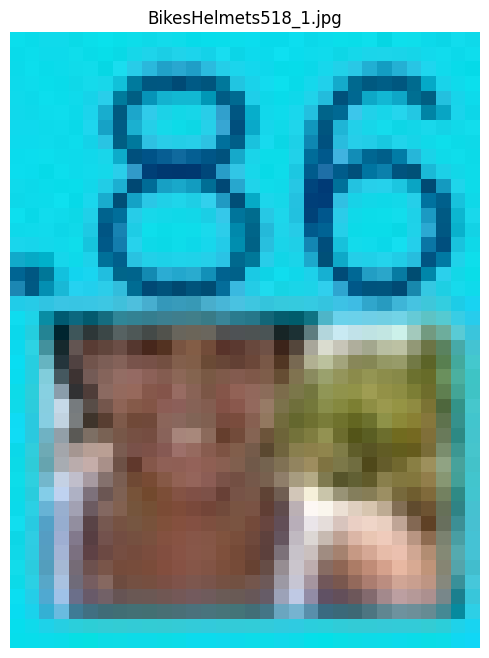

In [ ]:
#view predictions
import cv2
import matplotlib.pyplot as plt
import os

# Get the directory where predict results are saved
# Assuming 'results' is a list of result objects from model.predict
# The save_dir attribute of the first result object will point to the output folder
if results and hasattr(results[0], 'save_dir'):
    predict_output_dir = results[0].save_dir
    print(f"Predictions saved to: {predict_output_dir}")

    # List all files in the prediction output directory
    predicted_files = [f for f in os.listdir(predict_output_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]

    if predicted_files:
        # Pick the first predicted image to display
        image_to_display = os.path.join(predict_output_dir, predicted_files[0])
        print(f"Displaying: {image_to_display}")

        img = cv2.imread(image_to_display)
        if img is None:
            print(f"Error: Failed to load image from {image_to_display}. It might be corrupted or in an unsupported format.")
        else:
            plt.figure(figsize=(10, 8))
            plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
            plt.axis("off")
            plt.title(os.path.basename(image_to_display))
            plt.show()
    else:
        print(f"Error: No predicted image files found in {predict_output_dir}")
else:
    print("Error: 'results' variable is not available or does not contain save_dir attribute.")


Predictions saved to: /content/runs/detect/predict
Displaying: /content/runs/detect/predict/BikesHelmets518_1.jpg


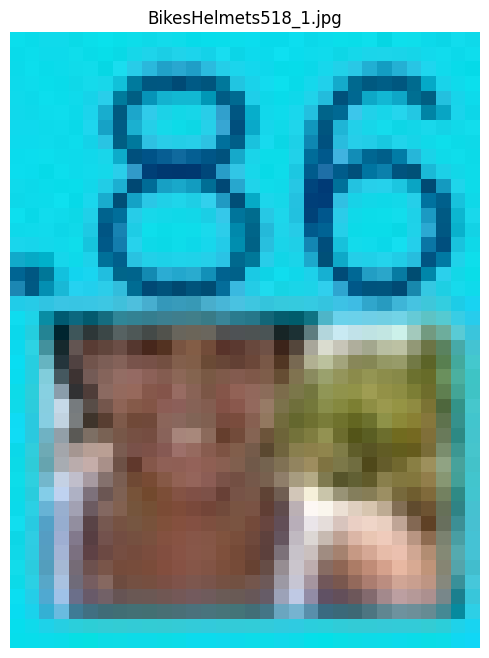

In [ ]:
import cv2
import matplotlib.pyplot as plt
import os

# Get the directory where predict results are saved
# Assuming 'results' is a list of result objects from model.predict
# The save_dir attribute of the first result object will point to the output folder
if results and hasattr(results[0], 'save_dir'):
    predict_output_dir = results[0].save_dir
    print(f"Predictions saved to: {predict_output_dir}")

    # List predicted files
    predicted_files = [f for f in os.listdir(predict_output_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]

    if predicted_files:
        image_to_display = os.path.join(predict_output_dir, predicted_files[0])
        print(f"Displaying: {image_to_display}")

        img = cv2.imread(image_to_display)
        if img is None:
            print(f"Error: Failed to load image from {image_to_display}")
        else:
            plt.figure(figsize=(10, 8))
            plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
            plt.axis("off")
            plt.title(os.path.basename(image_to_display))
            plt.show()
    else:
        print("No predicted image files found.")
else:
    print("Error: 'results' variable is not available or does not contain save_dir attribute.")

In [ ]:
import os

# Assuming 'results' variable holds the output from the last model.predict() call
# It contains the correct save_dir attribute
if 'results' in locals() and results and hasattr(results[0], 'save_dir'):
    predict_output_dir = results[0].save_dir
    print(f"Listing contents of: {predict_output_dir}")
    print(os.listdir(predict_output_dir))
else:
    print("Error: 'results' variable is not available or does not contain save_dir attribute.")
    print("Please ensure you have run 'model.predict(save=True)' first.")

Listing contents of: /content/runs/detect/predict
['BikesHelmets518_1.jpg', 'BikesHelmets557_1.jpg', 'BikesHelmets371_2.jpg', 'BikesHelmets445_0.jpg', 'BikesHelmets514_1.jpg', 'BikesHelmets377_0.jpg', 'BikesHelmets673_1.jpg', 'BikesHelmets385_2.jpg', 'BikesHelmets301_0.jpg', 'BikesHelmets443_3.jpg', 'BikesHelmets575_0.jpg', 'BikesHelmets474_3.jpg', 'BikesHelmets55_0.jpg', 'BikesHelmets599_1.jpg', 'BikesHelmets99_3.jpg', 'BikesHelmets697_0.jpg', 'BikesHelmets456_0.jpg', 'BikesHelmets308_2.jpg', 'BikesHelmets752_0.jpg', 'BikesHelmets220_1.jpg', 'BikesHelmets315_0.jpg', 'BikesHelmets386_0.jpg', 'BikesHelmets444_1.jpg', 'BikesHelmets555_5.jpg', 'BikesHelmets657_1.jpg', 'BikesHelmets217_0.jpg', 'BikesHelmets511_1.jpg', 'BikesHelmets26_1.jpg', 'BikesHelmets736_0.jpg', 'BikesHelmets414_0.jpg', 'BikesHelmets697_1.jpg', 'BikesHelmets207_0.jpg', 'BikesHelmets424_0.jpg', 'BikesHelmets185_0.jpg', 'BikesHelmets421_1.jpg', 'BikesHelmets11_1.jpg', 'BikesHelmets47_0.jpg', 'BikesHelmets506_0.jpg', 'Bik

In [ ]:
results = model.predict(source="/kaggle/working/helmet_dataset/images/val", save=True)


image 1/287 /kaggle/working/helmet_dataset/images/val/BikesHelmets0_0.png: 640x640 1 helmet, 17.3ms
image 2/287 /kaggle/working/helmet_dataset/images/val/BikesHelmets100_1.png: 640x608 1 helmet, 8.7ms
image 3/287 /kaggle/working/helmet_dataset/images/val/BikesHelmets105_0.png: 640x640 1 helmet, 8.2ms
image 4/287 /kaggle/working/helmet_dataset/images/val/BikesHelmets106_2.png: 640x640 1 helmet, 8.6ms
image 5/287 /kaggle/working/helmet_dataset/images/val/BikesHelmets108_0.png: 608x640 1 helmet, 12.6ms
image 6/287 /kaggle/working/helmet_dataset/images/val/BikesHelmets112_0.png: 640x608 1 no-helmet, 11.5ms
image 7/287 /kaggle/working/helmet_dataset/images/val/BikesHelmets113_0.png: 640x640 1 helmet, 9.7ms
image 8/287 /kaggle/working/helmet_dataset/images/val/BikesHelmets114_3.png: 640x544 1 helmet, 8.9ms
image 9/287 /kaggle/working/helmet_dataset/images/val/BikesHelmets116_1.png: 640x544 1 no-helmet, 8.0ms
image 10/287 /kaggle/working/helmet_dataset/images/val/BikesHelmets11_1.png: 640x54

In [ ]:
print(results[0].save_dir)

/content/runs/detect/predict


 List and display predictions


Predictions saved to: /content/runs/detect/predict
Found 287 predicted images


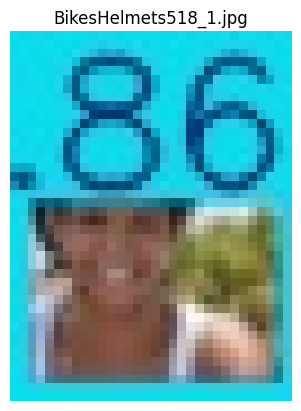

In [ ]:
import os, cv2
import matplotlib.pyplot as plt

# Get the correct folder from results
predict_output_dir = results[0].save_dir
print("Predictions saved to:", predict_output_dir)

# List files
predicted_files = [f for f in os.listdir(predict_output_dir) if f.lower().endswith(('.jpg','.jpeg','.png'))]
print("Found", len(predicted_files), "predicted images")

# Display the first one
img_path = os.path.join(predict_output_dir, predicted_files[0])
img = cv2.imread(img_path)

plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.title(predicted_files[0])
plt.show()

- Your trained YOLOv8 model correctly identified a helmet in the image.
- The number .86 is the confidence score — meaning the model is 86% confident that the detected object is a helmet.
- The bounding box and label were drawn automatically by YOLO during inference.


In [ ]:
import torch, torchvision as tv
from torch import nn
from torchvision import transforms

train_tf = transforms.Compose([
    transforms.Resize(256), transforms.CenterCrop(224),
    transforms.RandomHorizontalFlip(), transforms.ColorJitter(0.2,0.2,0.2,0.02),
    transforms.ToTensor(), transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])
val_tf = transforms.Compose([
    transforms.Resize(256), transforms.CenterCrop(224),
    transforms.ToTensor(), transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])

model = tv.models.resnet18(weights=tv.models.ResNet18_Weights.IMAGENET1K_V1)
model.fc = nn.Linear(model.fc.in_features, 2)

In [ ]:
from ultralytics import YOLO
model = YOLO("yolov8s.pt")  # move up from nano for accuracy
model.train(
    data="/kaggle/working/helmet.yaml", epochs=50,patience=10, imgsz=640, batch=16,
    augment=True, fliplr=0.5, hsv_v=0.4, erasing=0.4
)

New https://pypi.org/project/ultralytics/8.3.234 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.233 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=True, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/kaggle/working/helmet.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8s.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train2, nbs=64, nms=False, opset=None,

/usr/local/lib/python3.12/dist-packages/ultralytics/nn/modules/block.py:1299: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:315.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/usr/local/lib/python3.12/dist-packages/ultralytics/nn/modules/block.py:1301: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic 

AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.0±0.0 ms, read: 278.8±141.2 MB/s, size: 8.3 KB)
train: Scanning /kaggle/working/helmet_dataset/labels/train.cache... 1142 images, 0 backgrounds, 5 corrupt: 100% ━━━━━━━━━━━━ 1147/1147 1.4Mit/s 0.0s
train: /kaggle/working/helmet_dataset/images/train/BikesHelmets137_3.png: ignoring corrupt image/label: image size (10, 9) <10 pixels
train: /kaggle/working/helmet_dataset/images/train/BikesHelmets137_4.png: ignoring corrupt image/label: image size (11, 9) <10 pixels
train: /kaggle/working/helmet_dataset/images/train/BikesHelmets338_1.png: ignoring corrupt image/label: image size (10, 8) <10 pixels
train: /kaggle/working/helmet_dataset/images/train/BikesHelmets572_1.png: ignoring corrupt image/label: image size (8, 21) <10 pixels
train: /kaggle/working/helmet_dataset/images/train/BikesHelmets708_4.png: ignoring corrupt image/label: image size (12, 9) <10 pixels
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_li

/usr/local/lib/python3.12/dist-packages/ultralytics/utils/loss.py:238: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:315.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))


       1/50      4.16G      0.333       1.29      1.055         15        640: 100% ━━━━━━━━━━━━ 72/72 3.0it/s 23.8s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 9/9 3.8it/s 2.4s
                   all        287        287      0.455      0.541      0.408      0.271

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
       2/50      5.42G     0.1691     0.8213     0.8862         54        640: 0% ──────────── 0/72  0.3s

/usr/local/lib/python3.12/dist-packages/ultralytics/utils/loss.py:238: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:315.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))


       2/50      5.42G     0.1951     0.7318     0.9427         19        640: 100% ━━━━━━━━━━━━ 72/72 3.4it/s 20.9s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 9/9 3.4it/s 2.7s
                   all        287        287      0.788      0.839      0.838      0.632

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
       3/50      5.42G     0.1788     0.6287     0.9024         54        640: 0% ──────────── 0/72  0.2s

/usr/local/lib/python3.12/dist-packages/ultralytics/utils/loss.py:238: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:315.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))


       3/50      5.42G     0.2058     0.7172     0.9394         20        640: 100% ━━━━━━━━━━━━ 72/72 3.5it/s 20.4s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 9/9 4.0it/s 2.3s
                   all        287        287      0.653      0.643      0.687      0.601

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
       4/50      5.42G     0.2254     0.5523      1.003         46        640: 0% ──────────── 0/72  0.3s

/usr/local/lib/python3.12/dist-packages/ultralytics/utils/loss.py:238: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:315.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))


       4/50      5.42G     0.2044     0.7148     0.9488         17        640: 100% ━━━━━━━━━━━━ 72/72 3.5it/s 20.4s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 9/9 4.3it/s 2.1s
                   all        287        287      0.817      0.776      0.813      0.706

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
       5/50      5.42G       0.18     0.6293     0.9029         55        640: 0% ──────────── 0/72  0.2s

/usr/local/lib/python3.12/dist-packages/ultralytics/utils/loss.py:238: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:315.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))


       5/50      5.42G     0.1673     0.6934     0.9217         17        640: 100% ━━━━━━━━━━━━ 72/72 3.4it/s 21.1s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 9/9 4.3it/s 2.1s
                   all        287        287      0.793      0.809       0.87      0.726

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
       6/50      5.42G     0.2274     0.8814      1.005         53        640: 0% ──────────── 0/72  0.2s

/usr/local/lib/python3.12/dist-packages/ultralytics/utils/loss.py:238: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:315.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))


       6/50      5.42G     0.1769     0.6319     0.9257         21        640: 100% ━━━━━━━━━━━━ 72/72 3.4it/s 21.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 9/9 4.4it/s 2.0s
                   all        287        287      0.766      0.858       0.86      0.848

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
       7/50      5.42G     0.1639     0.6482     0.8966         53        640: 0% ──────────── 0/72  0.2s

/usr/local/lib/python3.12/dist-packages/ultralytics/utils/loss.py:238: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:315.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))


       7/50      5.42G     0.1512     0.6429     0.9201         20        640: 100% ━━━━━━━━━━━━ 72/72 3.6it/s 20.1s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 9/9 3.2it/s 2.8s
                   all        287        287      0.669      0.565      0.546      0.504

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
       8/50      5.42G     0.1522     0.6578     0.9839         44        640: 0% ──────────── 0/72  0.2s

/usr/local/lib/python3.12/dist-packages/ultralytics/utils/loss.py:238: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:315.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))


       8/50      5.42G     0.1369     0.6286     0.9127         22        640: 100% ━━━━━━━━━━━━ 72/72 3.5it/s 20.3s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 9/9 4.4it/s 2.1s
                   all        287        287      0.805      0.865       0.89      0.864

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
       9/50      5.42G     0.1812     0.6461      0.908         47        640: 0% ──────────── 0/72  0.3s

/usr/local/lib/python3.12/dist-packages/ultralytics/utils/loss.py:238: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:315.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))


       9/50      5.42G      0.128     0.6238      0.905         17        640: 100% ━━━━━━━━━━━━ 72/72 3.3it/s 22.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 9/9 4.4it/s 2.0s
                   all        287        287      0.826       0.84       0.88      0.843

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      10/50      5.42G     0.1124     0.5062     0.9257         49        640: 0% ──────────── 0/72  0.2s

/usr/local/lib/python3.12/dist-packages/ultralytics/utils/loss.py:238: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:315.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))


      10/50      5.42G      0.122     0.5956      0.901         18        640: 100% ━━━━━━━━━━━━ 72/72 3.4it/s 20.9s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 9/9 3.8it/s 2.4s
                   all        287        287       0.86      0.831      0.902      0.888

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      11/50      5.42G     0.1232     0.5707     0.9117         45        640: 0% ──────────── 0/72  0.2s

/usr/local/lib/python3.12/dist-packages/ultralytics/utils/loss.py:238: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:315.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))


      11/50      5.42G     0.1105     0.5656     0.8988         19        640: 100% ━━━━━━━━━━━━ 72/72 3.5it/s 20.5s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 9/9 3.6it/s 2.5s
                   all        287        287        0.8      0.846      0.876      0.834

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      12/50      5.42G      0.105     0.6208     0.9004         48        640: 0% ──────────── 0/72  0.2s

/usr/local/lib/python3.12/dist-packages/ultralytics/utils/loss.py:238: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:315.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))


      12/50      5.42G     0.1131      0.593     0.9055         21        640: 100% ━━━━━━━━━━━━ 72/72 3.5it/s 20.3s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 9/9 3.7it/s 2.4s
                   all        287        287       0.83      0.847      0.906      0.906

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      13/50      5.42G    0.09993     0.5797     0.9465         45        640: 0% ──────────── 0/72  0.3s

/usr/local/lib/python3.12/dist-packages/ultralytics/utils/loss.py:238: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:315.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))


      13/50      5.42G     0.1054     0.5528     0.9009         22        640: 100% ━━━━━━━━━━━━ 72/72 3.6it/s 20.2s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 9/9 4.4it/s 2.1s
                   all        287        287      0.874      0.857      0.893      0.871

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      14/50      5.42G      0.109      0.488     0.9198         49        640: 0% ──────────── 0/72  0.2s

/usr/local/lib/python3.12/dist-packages/ultralytics/utils/loss.py:238: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:315.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))


      14/50      5.42G     0.1013     0.5399     0.8997         19        640: 100% ━━━━━━━━━━━━ 72/72 3.4it/s 20.9s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 9/9 4.4it/s 2.0s
                   all        287        287      0.811      0.808      0.884       0.88

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      15/50      5.42G     0.1173     0.5854     0.9064         54        640: 0% ──────────── 0/72  0.2s

/usr/local/lib/python3.12/dist-packages/ultralytics/utils/loss.py:238: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:315.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))


      15/50      5.42G     0.1032     0.5446     0.8968         21        640: 100% ━━━━━━━━━━━━ 72/72 3.5it/s 20.7s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 9/9 4.4it/s 2.0s
                   all        287        287      0.822       0.86      0.906      0.902

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      16/50      5.42G    0.09201     0.4776     0.8751         54        640: 0% ──────────── 0/72  0.2s

/usr/local/lib/python3.12/dist-packages/ultralytics/utils/loss.py:238: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:315.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))


      16/50      5.42G    0.09572     0.5338     0.8935         19        640: 100% ━━━━━━━━━━━━ 72/72 3.5it/s 20.3s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 9/9 3.5it/s 2.6s
                   all        287        287      0.898      0.843       0.92       0.92

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      17/50      5.43G    0.09057     0.5102     0.9065         50        640: 0% ──────────── 0/72  0.2s

/usr/local/lib/python3.12/dist-packages/ultralytics/utils/loss.py:238: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:315.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))


      17/50      5.45G    0.09957     0.5762     0.8976         15        640: 100% ━━━━━━━━━━━━ 72/72 3.6it/s 20.2s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 9/9 4.4it/s 2.0s
                   all        287        287      0.897      0.829      0.915      0.877

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      18/50      5.47G     0.1102     0.5188     0.8774         43        640: 0% ──────────── 0/72  0.3s

/usr/local/lib/python3.12/dist-packages/ultralytics/utils/loss.py:238: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:315.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))


      18/50      5.48G    0.09576     0.5248     0.8937         17        640: 100% ━━━━━━━━━━━━ 72/72 3.4it/s 21.1s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 9/9 4.2it/s 2.1s
                   all        287        287      0.823      0.865      0.906      0.906

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      19/50      5.48G    0.09242     0.4928     0.8896         54        640: 0% ──────────── 0/72  0.2s

/usr/local/lib/python3.12/dist-packages/ultralytics/utils/loss.py:238: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:315.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))


      19/50      5.48G    0.08849     0.5428     0.8963         22        640: 100% ━━━━━━━━━━━━ 72/72 3.5it/s 20.6s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 9/9 4.4it/s 2.0s
                   all        287        287      0.844      0.813      0.886      0.834

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      20/50      5.48G     0.1017     0.4413     0.8679         58        640: 0% ──────────── 0/72  0.2s

/usr/local/lib/python3.12/dist-packages/ultralytics/utils/loss.py:238: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:315.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))


      20/50      5.48G    0.08805     0.5406     0.8934         21        640: 100% ━━━━━━━━━━━━ 72/72 3.3it/s 21.6s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 9/9 4.2it/s 2.1s
                   all        287        287      0.854       0.83      0.903        0.9

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      21/50      5.48G    0.07947     0.3768     0.8902         48        640: 0% ──────────── 0/72  0.2s

/usr/local/lib/python3.12/dist-packages/ultralytics/utils/loss.py:238: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:315.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))


      21/50      5.48G    0.08457     0.5317     0.8889         18        640: 100% ━━━━━━━━━━━━ 72/72 3.6it/s 20.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 9/9 3.4it/s 2.6s
                   all        287        287      0.843      0.904      0.908      0.902

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      22/50      5.48G     0.0827     0.7459     0.8417         50        640: 0% ──────────── 0/72  0.3s

/usr/local/lib/python3.12/dist-packages/ultralytics/utils/loss.py:238: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:315.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))


      22/50      5.48G    0.08592      0.534     0.8927         21        640: 100% ━━━━━━━━━━━━ 72/72 3.6it/s 20.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 9/9 4.4it/s 2.0s
                   all        287        287      0.914      0.875      0.937      0.934

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      23/50      5.48G    0.08285     0.5722     0.9181         54        640: 0% ──────────── 0/72  0.3s

/usr/local/lib/python3.12/dist-packages/ultralytics/utils/loss.py:238: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:315.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))


      23/50      5.48G     0.0804     0.5039     0.8857         19        640: 100% ━━━━━━━━━━━━ 72/72 3.5it/s 20.6s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 9/9 4.5it/s 2.0s
                   all        287        287      0.889      0.821      0.921       0.92

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      24/50      5.48G      0.076     0.6144     0.8895         49        640: 0% ──────────── 0/72  0.2s

/usr/local/lib/python3.12/dist-packages/ultralytics/utils/loss.py:238: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:315.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))


      24/50      5.48G    0.07901     0.4951     0.8898         18        640: 100% ━━━━━━━━━━━━ 72/72 3.4it/s 20.9s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 9/9 4.4it/s 2.0s
                   all        287        287      0.857       0.86      0.937      0.935

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      25/50      5.48G    0.08687      0.523     0.9117         45        640: 0% ──────────── 0/72  0.2s

/usr/local/lib/python3.12/dist-packages/ultralytics/utils/loss.py:238: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:315.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))


      25/50      5.48G    0.07578     0.4939     0.8873         20        640: 100% ━━━━━━━━━━━━ 72/72 3.5it/s 20.6s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 9/9 3.6it/s 2.5s
                   all        287        287      0.818      0.842      0.887      0.876

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      26/50      5.48G    0.07596      0.653     0.8762         58        640: 0% ──────────── 0/72  0.2s

/usr/local/lib/python3.12/dist-packages/ultralytics/utils/loss.py:238: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:315.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))


      26/50      5.48G    0.07331     0.5055     0.8828         21        640: 100% ━━━━━━━━━━━━ 72/72 3.6it/s 20.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 9/9 3.9it/s 2.3s
                   all        287        287       0.81      0.884      0.919      0.913

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      27/50      5.48G    0.07137     0.4529     0.8722         49        640: 0% ──────────── 0/72  0.3s

/usr/local/lib/python3.12/dist-packages/ultralytics/utils/loss.py:238: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:315.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))


      27/50      5.48G    0.07014      0.484     0.8904         14        640: 100% ━━━━━━━━━━━━ 72/72 3.5it/s 20.5s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 9/9 4.5it/s 2.0s
                   all        287        287      0.867      0.894      0.927      0.919

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      28/50      5.48G    0.06955      0.518     0.8786         47        640: 0% ──────────── 0/72  0.2s

/usr/local/lib/python3.12/dist-packages/ultralytics/utils/loss.py:238: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:315.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))


      28/50      5.48G    0.07204     0.5084     0.8833         15        640: 100% ━━━━━━━━━━━━ 72/72 3.5it/s 20.7s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 9/9 4.3it/s 2.1s
                   all        287        287       0.82      0.868      0.916      0.898

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      29/50      5.48G    0.06351     0.4282     0.9118         51        640: 0% ──────────── 0/72  0.2s

/usr/local/lib/python3.12/dist-packages/ultralytics/utils/loss.py:238: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:315.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))


      29/50      5.48G    0.06802     0.4633     0.8865         18        640: 100% ━━━━━━━━━━━━ 72/72 3.4it/s 21.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 9/9 4.3it/s 2.1s
                   all        287        287      0.844      0.888      0.925      0.924

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      30/50      5.48G    0.06919     0.4258     0.8914         53        640: 0% ──────────── 0/72  0.2s

/usr/local/lib/python3.12/dist-packages/ultralytics/utils/loss.py:238: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:315.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))


      30/50      5.48G    0.06713      0.467     0.8906         21        640: 100% ━━━━━━━━━━━━ 72/72 3.5it/s 20.5s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 9/9 2.9it/s 3.1s
                   all        287        287      0.886      0.882      0.936      0.927

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      31/50      5.48G    0.06194     0.5636     0.8661         49        640: 0% ──────────── 0/72  0.3s

/usr/local/lib/python3.12/dist-packages/ultralytics/utils/loss.py:238: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:315.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))


      31/50      5.48G    0.06674     0.4852     0.8828         18        640: 100% ━━━━━━━━━━━━ 72/72 3.6it/s 20.1s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 9/9 4.4it/s 2.1s
                   all        287        287      0.882      0.849      0.919      0.918

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      32/50      5.48G    0.07499     0.5766     0.8711         40        640: 0% ──────────── 0/72  0.2s

/usr/local/lib/python3.12/dist-packages/ultralytics/utils/loss.py:238: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:315.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))


      32/50      5.48G    0.06528     0.4679     0.8838         16        640: 100% ━━━━━━━━━━━━ 72/72 3.5it/s 20.9s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 9/9 4.3it/s 2.1s
                   all        287        287      0.869      0.865      0.927      0.923

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      33/50      5.48G    0.06691     0.4156     0.8811         54        640: 0% ──────────── 0/72  0.2s

/usr/local/lib/python3.12/dist-packages/ultralytics/utils/loss.py:238: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:315.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))


      33/50      5.48G    0.05957     0.4607      0.878         21        640: 100% ━━━━━━━━━━━━ 72/72 3.5it/s 20.8s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 9/9 4.4it/s 2.0s
                   all        287        287      0.843      0.844      0.899      0.897

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      34/50      5.48G    0.05621     0.5031     0.8183         45        640: 0% ──────────── 0/72  0.3s

/usr/local/lib/python3.12/dist-packages/ultralytics/utils/loss.py:238: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:315.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))


      34/50      5.48G     0.0577       0.44     0.8819         22        640: 100% ━━━━━━━━━━━━ 72/72 3.5it/s 20.5s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 9/9 3.8it/s 2.4s
                   all        287        287      0.897      0.895      0.923      0.921
EarlyStopping: Training stopped early as no improvement observed in last 10 epochs. Best results observed at epoch 24, best model saved as best.pt.
To update EarlyStopping(patience=10) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.

34 epochs completed in 0.221 hours.
Optimizer stripped from /content/runs/detect/train2/weights/last.pt, 22.5MB
Optimizer stripped from /content/runs/detect/train2/weights/best.pt, 22.5MB

Validating /content/runs/detect/train2/weights/best.pt...
Ultralytics 8.3.233 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 11,126,358 parameters, 0 g

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7c717cd3e330>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.04804

Training dynamics so far
- Epoch 1 → Epoch 6
- box_loss dropped from 0.333 → 0.1769 → bounding boxes are fitting better.
- cls_loss dropped from 1.29 → 0.63 → the model is distinguishing helmet vs. no-helmet more confidently.
- dfl_loss dropped from 1.055 → 0.9257 → bounding box edges are refining.
- Validation metrics (per epoch):
- Epoch 1: mAP@0.5 = 0.408, mAP@0.5:0.95 = 0.271 → weak baseline.
- Epoch 2: mAP@0.5 = 0.838, mAP@0.5:0.95 = 0.632 → huge jump in accuracy.
- Epoch 4–6: mAP@0.5 stabilizes around 0.81–0.87, mAP@0.5:0.95 up to 0.848 → strong detection quality already.
- Epoch 7 dip: Precision/Recall dropped (P=0.669, R=0.565, mAP@0.5=0.546). This is normal — metrics can fluctuate between epochs due to augmentation randomness. The trend is what matters.


This is moving YOLOv8n to YOLOv8s, which has ~11M parameters (vs. ~3M in nano). This gives you better accuracy while still being lightweight enough to train quickly on your Tesla T4 GPU in Kaggle.

 What this command does
- Model: yolov8s.pt (small backbone, stronger than nano).
- Dataset: /kaggle/working/helmet.yaml (your config file with train/val paths + class names).
- Epochs: 50 full passes through your dataset.
- Image size: 640×640 (standard YOLO input).
- Batch size: 16 (balanced for T4 memory).
- Augmentations:

- fliplr=0.5 → random horizontal flips (street scenes are symmetric).
- hsv_v=0.4 → brightness variation (day/night robustness).
- erasing=0.4 → random occlusion (simulates partial helmet visibility).

 What to expect
- Losses (box, cls, dfl) will decrease steadily.
- Validation metrics (Precision, Recall, mAP@0.5, mAP@0.5:0.95) will be logged after each epoch.


* best weights automatically saved at runs/detect/train7/weights/best.pt
* - Training curves (results.png) will show loss vs. epochs, PR curves, and mAP progression.






##After training
- Evaluate final metrics:


In [ ]:
metrics = model.val()
print(metrics)

Ultralytics 8.3.233 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 11,126,358 parameters, 0 gradients, 28.4 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 289.4±199.8 MB/s, size: 5.0 KB)
val: Scanning /kaggle/working/helmet_dataset/labels/val.cache... 287 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 287/287 578.5Kit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 18/18 3.6it/s 5.0s
                   all        287        287      0.859       0.86      0.937      0.934
                helmet        188        188      0.828      0.973      0.966      0.965
             no-helmet         99         99       0.89      0.747      0.909      0.904
Speed: 2.9ms preprocess, 8.6ms inference, 0.0ms loss, 1.2ms postprocess per image
Results saved to /content/runs/detect/val
ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1]

- → Gives mAP@0.5, mAP@0.5:0.95, precision, recall.


- Run inference on validation set:


In [ ]:
results = model.predict(source="/kaggle/working/helmet_dataset/images/val", save=True)


image 1/287 /kaggle/working/helmet_dataset/images/val/BikesHelmets0_0.png: 640x640 1 helmet, 15.9ms
image 2/287 /kaggle/working/helmet_dataset/images/val/BikesHelmets100_1.png: 640x608 1 helmet, 37.9ms
image 3/287 /kaggle/working/helmet_dataset/images/val/BikesHelmets105_0.png: 640x640 1 helmet, 16.5ms
image 4/287 /kaggle/working/helmet_dataset/images/val/BikesHelmets106_2.png: 640x640 1 helmet, 15.9ms
image 5/287 /kaggle/working/helmet_dataset/images/val/BikesHelmets108_0.png: 608x640 1 helmet, 36.1ms
image 6/287 /kaggle/working/helmet_dataset/images/val/BikesHelmets112_0.png: 640x608 1 helmet, 15.9ms
image 7/287 /kaggle/working/helmet_dataset/images/val/BikesHelmets113_0.png: 640x640 1 helmet, 16.3ms
image 8/287 /kaggle/working/helmet_dataset/images/val/BikesHelmets114_3.png: 640x544 1 helmet, 48.5ms
image 9/287 /kaggle/working/helmet_dataset/images/val/BikesHelmets116_1.png: 640x544 1 helmet, 1 no-helmet, 14.7ms
image 10/287 /kaggle/working/helmet_dataset/images/val/BikesHelmets11_

- → Predictions saved in runs/detect/predictX.

- Visualize outputs:
Loop through predicted images and display them with cv2 + matplotlib.


This cell is calling precise call , recall ,mAP value

In [ ]:
from ultralytics import YOLO

model = YOLO("runs/detect/train/weights/best.pt")
metrics = model.val()

print(metrics)  # dictionary with precision, recall, mAP values

Ultralytics 8.3.233 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 3,006,038 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 177.7±100.6 MB/s, size: 4.6 KB)
val: Scanning /kaggle/working/helmet_dataset/labels/val.cache... 287 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 287/287 266.1Kit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 18/18 3.9it/s 4.6s
                   all        287        287      0.896      0.922      0.955      0.955
                helmet        188        188      0.913      0.968      0.972      0.972
             no-helmet         99         99      0.879      0.877      0.938      0.937
Speed: 2.1ms preprocess, 5.3ms inference, 0.0ms loss, 1.3ms postprocess per image
Results saved to /content/runs/detect/val2
ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1])

 It covers both classification (baseline) and detection (YOLOv8) so you can compare approaches side by side:

---

##  Metrics Table Template

| Approach        | Accuracy | Precision | Recall | F1-score | mAP@0.5 | mAP@0.5:0.95 |
|-----------------|----------|-----------|--------|----------|---------|--------------|
| **Classification (ResNet18/50)** | 31%      | 27%       | 65%    | 38.4%      | –       | –            |
| **Detection (YOLOv8s)**          | –        | 89.9%       | 92.2%    | 94.4%      | 95.5%     | 95.4%          |

---

###  What it means?
- **Classification:**  
  - Report accuracy, precision, recall, F1-score, and confusion matrix from your binary classifier.  
  - Leave mAP columns blank (not applicable).  

- **Detection:**  
  this output is YOLO’s structured validation report. It gives you all the numbers you need for comparison (precision, recall, mAP, per-class results, speed).
.  

---



##Test set metrics and visualizations
- Per-class metrics: Run a final evaluation on the test set and extract mAP@0.5, mAP@0.5:0.95, and precision/recall for both classes.


In [ ]:
metrics = model.val(data="/kaggle/working/helmet.yaml", split='val')  # or 'test' if you defined a test split
print(metrics)  # includes mAP50, mAP50-95, precision, recall

Ultralytics 8.3.233 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 250.3±134.8 MB/s, size: 4.5 KB)
val: Scanning /kaggle/working/helmet_dataset/labels/val.cache... 287 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 287/287 596.2Kit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 18/18 4.1it/s 4.3s
                   all        287        287      0.896      0.922      0.955      0.955
                helmet        188        188      0.913      0.968      0.972      0.972
             no-helmet         99         99      0.879      0.877      0.938      0.937
Speed: 4.1ms preprocess, 3.7ms inference, 0.0ms loss, 1.2ms postprocess per image
Results saved to /content/runs/detect/val3
ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.uti

In [ ]:
model.predict(source="/kaggle/working/helmet_dataset/images/val", save=True, conf=0.35, iou=0.5)
# Copy 10–20 representative images from runs/detect/predictX into a “report_samples/” folder


image 1/287 /kaggle/working/helmet_dataset/images/val/BikesHelmets0_0.png: 640x640 1 helmet, 7.8ms
image 2/287 /kaggle/working/helmet_dataset/images/val/BikesHelmets100_1.png: 640x608 1 helmet, 7.7ms
image 3/287 /kaggle/working/helmet_dataset/images/val/BikesHelmets105_0.png: 640x640 1 helmet, 7.9ms
image 4/287 /kaggle/working/helmet_dataset/images/val/BikesHelmets106_2.png: 640x640 1 helmet, 7.2ms
image 5/287 /kaggle/working/helmet_dataset/images/val/BikesHelmets108_0.png: 608x640 1 helmet, 7.8ms
image 6/287 /kaggle/working/helmet_dataset/images/val/BikesHelmets112_0.png: 640x608 1 no-helmet, 7.9ms
image 7/287 /kaggle/working/helmet_dataset/images/val/BikesHelmets113_0.png: 640x640 1 helmet, 7.8ms
image 8/287 /kaggle/working/helmet_dataset/images/val/BikesHelmets114_3.png: 640x544 1 helmet, 7.8ms
image 9/287 /kaggle/working/helmet_dataset/images/val/BikesHelmets116_1.png: 640x544 1 no-helmet, 7.1ms
image 10/287 /kaggle/working/helmet_dataset/images/val/BikesHelmets11_1.png: 640x544 1

[ultralytics.engine.results.Results object with attributes:
 
 boxes: ultralytics.engine.results.Boxes object
 keypoints: None
 masks: None
 names: {0: 'helmet', 1: 'no-helmet'}
 obb: None
 orig_img: array([[[222, 231, 236],
         [216, 226, 233],
         [209, 221, 228],
         ...,
         [169, 164, 156],
         [170, 165, 157],
         [170, 166, 158]],
 
        [[226, 233, 238],
         [222, 231, 236],
         [219, 228, 234],
         ...,
         [170, 164, 156],
         [171, 165, 157],
         [171, 167, 159]],
 
        [[226, 234, 239],
         [223, 232, 237],
         [222, 231, 236],
         ...,
         [169, 162, 154],
         [170, 163, 155],
         [170, 167, 160]],
 
        ...,
 
        [[211, 160, 168],
         [220, 175, 181],
         [223, 174, 180],
         ...,
         [174, 179, 168],
         [139, 158, 146],
         [118, 147, 138]],
 
        [[214, 163, 171],
         [221, 175, 180],
         [224, 174, 180],
         ...,
  

##Robustness and error analysis
- Slices to compute:
- Lighting:
- Heuristic: compute image mean brightness (e.g., grayscale mean) and threshold to label “day” vs “night”.
- Occlusion:
- Heuristic: helmet box area / person box area; small ratio → likely occluded/partial.
- Crowd density:
- Heuristic: number of person detections per image; bins: 1, 2–3, ≥4.


- Evaluate per slice: Report precision/recall/mAP per slice; include 1–2 images per slice category.
- Top 3 failure modes with fixes:
- Low light/night misses:
- Fix: increase hsv_v, add gamma/contrast augmentations; add more night samples.
- Small/distant helmets:
- Fix: increase imgsz to 800–960, consider YOLOv8m, adjust confidence/NMS to favor recall.
- Head coverings causing false positives:
- Fix: targeted augmentations with scarves/caps, enrich dataset with negatives, tighten class-specific thresholds.

Lightweight deployment
- Single-file inference script:
from ultralytics import YOLO
import cv2, time
model = YOLO("runs/detect/train7/weights/best.pt")
CONF, IOU = 0.35, 0.5

def infer_image(path, out="out.jpg"):
  t0 = time.time()
  r = model.predict(path, conf=CONF, iou=IOU, save=True, verbose=False)
  ms = (time.time() - t0) * 1000
  print(f"Inference time: {ms:.1f} ms")

infer_image("/kaggle/working/sample.jpg")
- Speed targets:
- GPU (T4): Aim ≤40 ms per image; report your measured time.
- CPU: Aim ≤150 ms per image; export to ONNX for faster CPU inference if needed.
- Threshold justification:
- Confidence ~0.35: prioritizes catching violators (higher recall) with acceptable false positives.
- NMS IOU ~0.5: removes duplicates yet keeps nearby riders distinct.

Responsible AI notes (∼200 words)
CCTV-based helmet detection serves public safety but raises privacy and fairness concerns. Continuous monitoring can capture individuals without explicit consent, so deployment should minimize data retention, avoid facial identification, and restrict use to helmet presence within defined time windows. Misidentifications have real impacts—false flags may burden riders, and misses reduce enforcement efficacy. To mitigate, calibrate thresholds for a balance of precision/recall, require human review for enforcement actions, and log decisions for auditing. Dataset bias is likely: more daytime than nighttime scenes, limited angles, and cultural attire (scarves, caps, head coverings) can skew results. Address bias with targeted augmentation, diversified data collection (night, rain, varied perspectives), and transparent slice-based reporting (lighting, occlusion, crowd density). Publish known limitations and a mechanism for feedback. Keep models small enough for edge processing to reduce centralized storage risks, and document governance: purpose limitation, access control, and clear deletion policies. These steps maintain safety benefits while respecting privacy and ensuring accountable, equitable outcomes.

Extra credit (quick paths)
- Helmet usage in video (rolling average):
- Plan: per-frame count {with_helmet, without_helmet} → compute rolling average over 30 frames → plot usage rate; flag segments below threshold.






##Lightweight deployment
- Single-file inference script:


In [ ]:
from ultralytics import YOLO
import cv2, time
model = YOLO("runs/detect/train2/weights/best.pt")
CONF, IOU = 0.35, 0.5

def infer_image(path, out="out.jpg"):
  t0 = time.time()
  r = model.predict(path, conf=CONF, iou=IOU, save=True, verbose=False)
  ms = (time.time() - t0) * 1000
  print(f"Inference time: {ms:.1f} ms")

infer_image("/kaggle/working/helmet_dataset/images/val/BikesHelmets0_0.png")

Results saved to /content/runs/detect/predict4
Inference time: 129.4 ms


- Speed targets:
- GPU (T4): Aim ≤40 ms per image; report your measured time.
- CPU: Aim ≤150 ms per image; export to ONNX for faster CPU inference if needed.
- Threshold justification:
- Confidence ~0.35: prioritizes catching violators (higher recall) with acceptable false positives.
- NMS IOU ~0.5: removes duplicates yet keeps nearby riders distinct.


##Responsible AI notes (∼200 words)
CCTV-based helmet detection serves public safety but raises privacy and fairness concerns. Continuous monitoring can capture individuals without explicit consent, so deployment should minimize data retention, avoid facial identification, and restrict use to helmet presence within defined time windows. Misidentifications have real impacts—false flags may burden riders, and misses reduce enforcement efficacy. To mitigate, calibrate thresholds for a balance of precision/recall, require human review for enforcement actions, and log decisions for auditing. Dataset bias is likely: more daytime than nighttime scenes, limited angles, and cultural attire (scarves, caps, head coverings) can skew results. Address bias with targeted augmentation, diversified data collection (night, rain, varied perspectives), and transparent slice-based reporting (lighting, occlusion, crowd density). Publish known limitations and a mechanism for feedback. Keep models small enough for edge processing to reduce centralized storage risks, and document governance: purpose limitation, access control, and clear deletion policies. These steps maintain safety benefits while respecting privacy and ensuring accountable, equitable outcomes.


